# **Implementation Notebook**

**Load in packages and inmport dataset**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import mylib as my
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import mylib as my
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, ParameterSampler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay

df = pd.read_csv('diabetes.csv')
# print(df.isna().sum()) No NaN values
# print((df == 0).sum()) Several 0 values, this data is important, fill with the mean
# df.shape 768 Rows, 9 Columns

## Data Statistics and Visualizations

**Replace NULL values with the mean**

In [2]:
columns_replace= ['BloodPressure', 'Glucose', 'SkinThickness', 'Insulin', 'BMI'] #These columns should never have 0 (NULL)

for column in columns_replace :
   me= int(df[column].mean(skipna=True))
   df[column] = df[column].replace(0,me)
print((df == 0).sum())

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


**Check for any coorelations between variables**

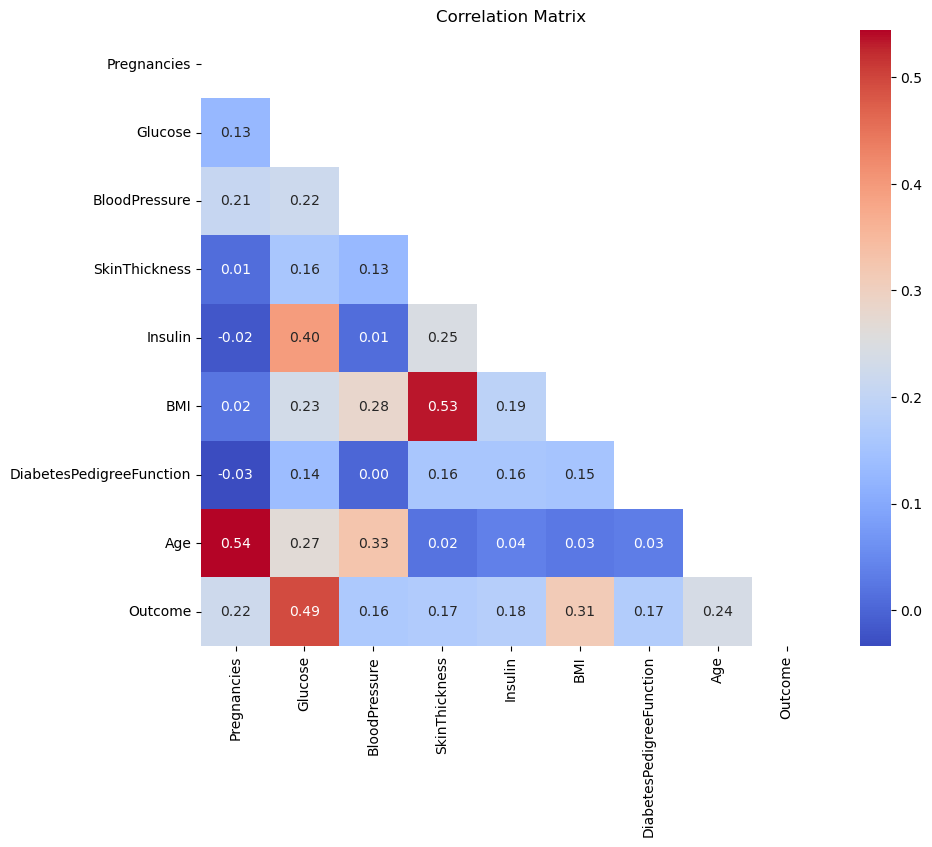

In [3]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap of the correlation matrix with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix')
plt.show()

**Check shape of the data**

Nothing too concerning other than the massive peaks where there was missing data in SkinThickness and Insulin. (Removing these columns didn't change the results so we kept them in.)

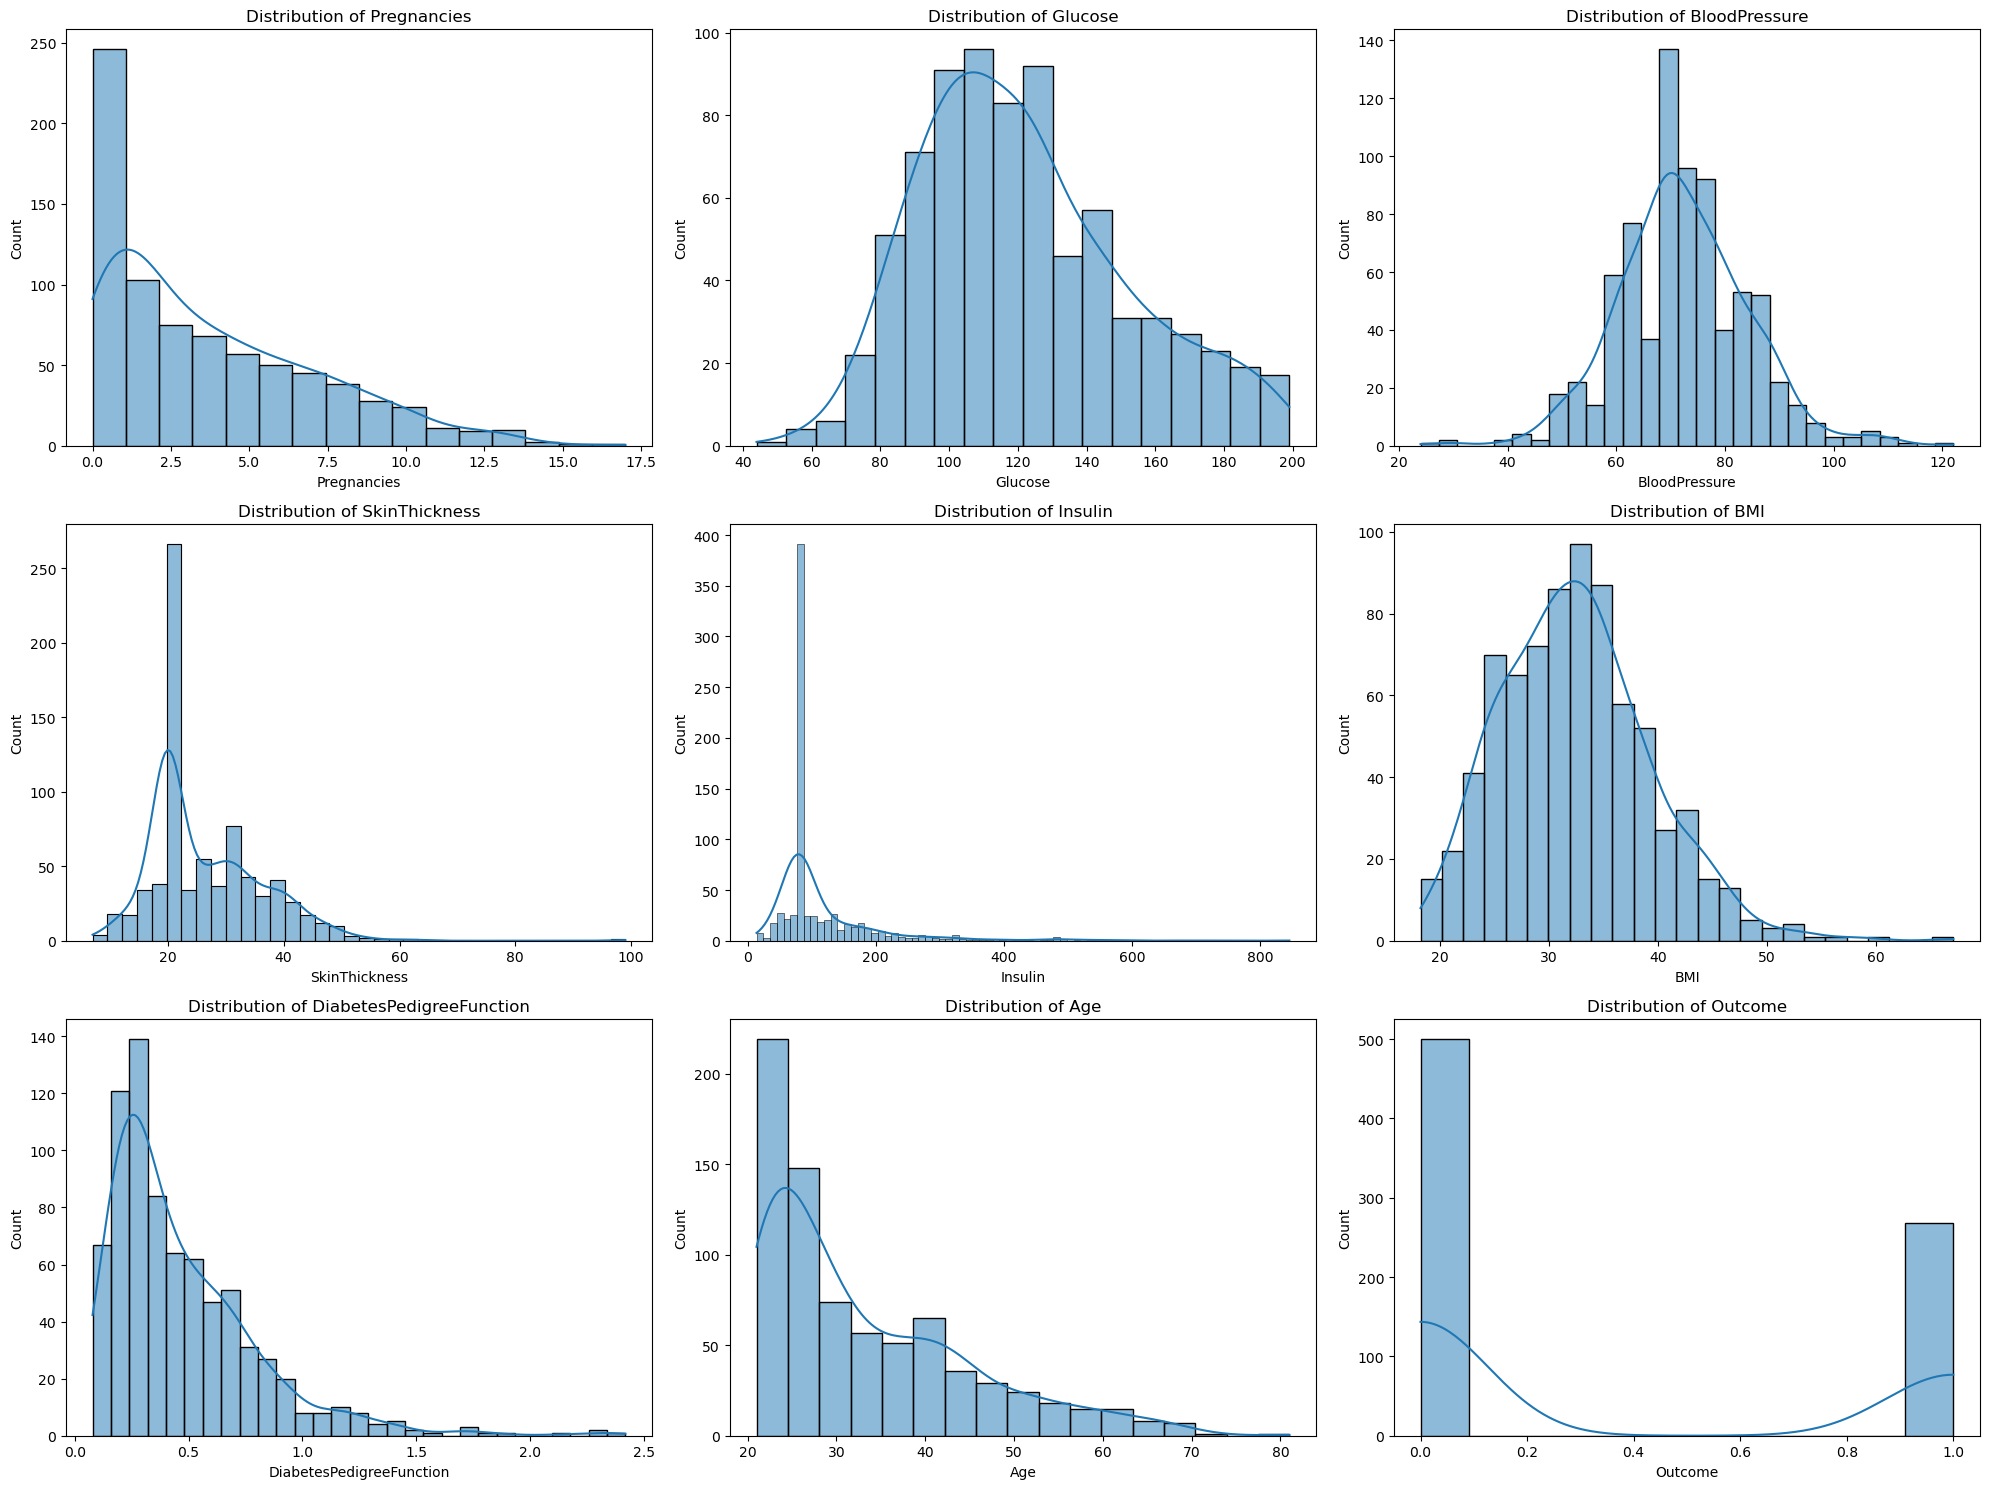

In [4]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i) 
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

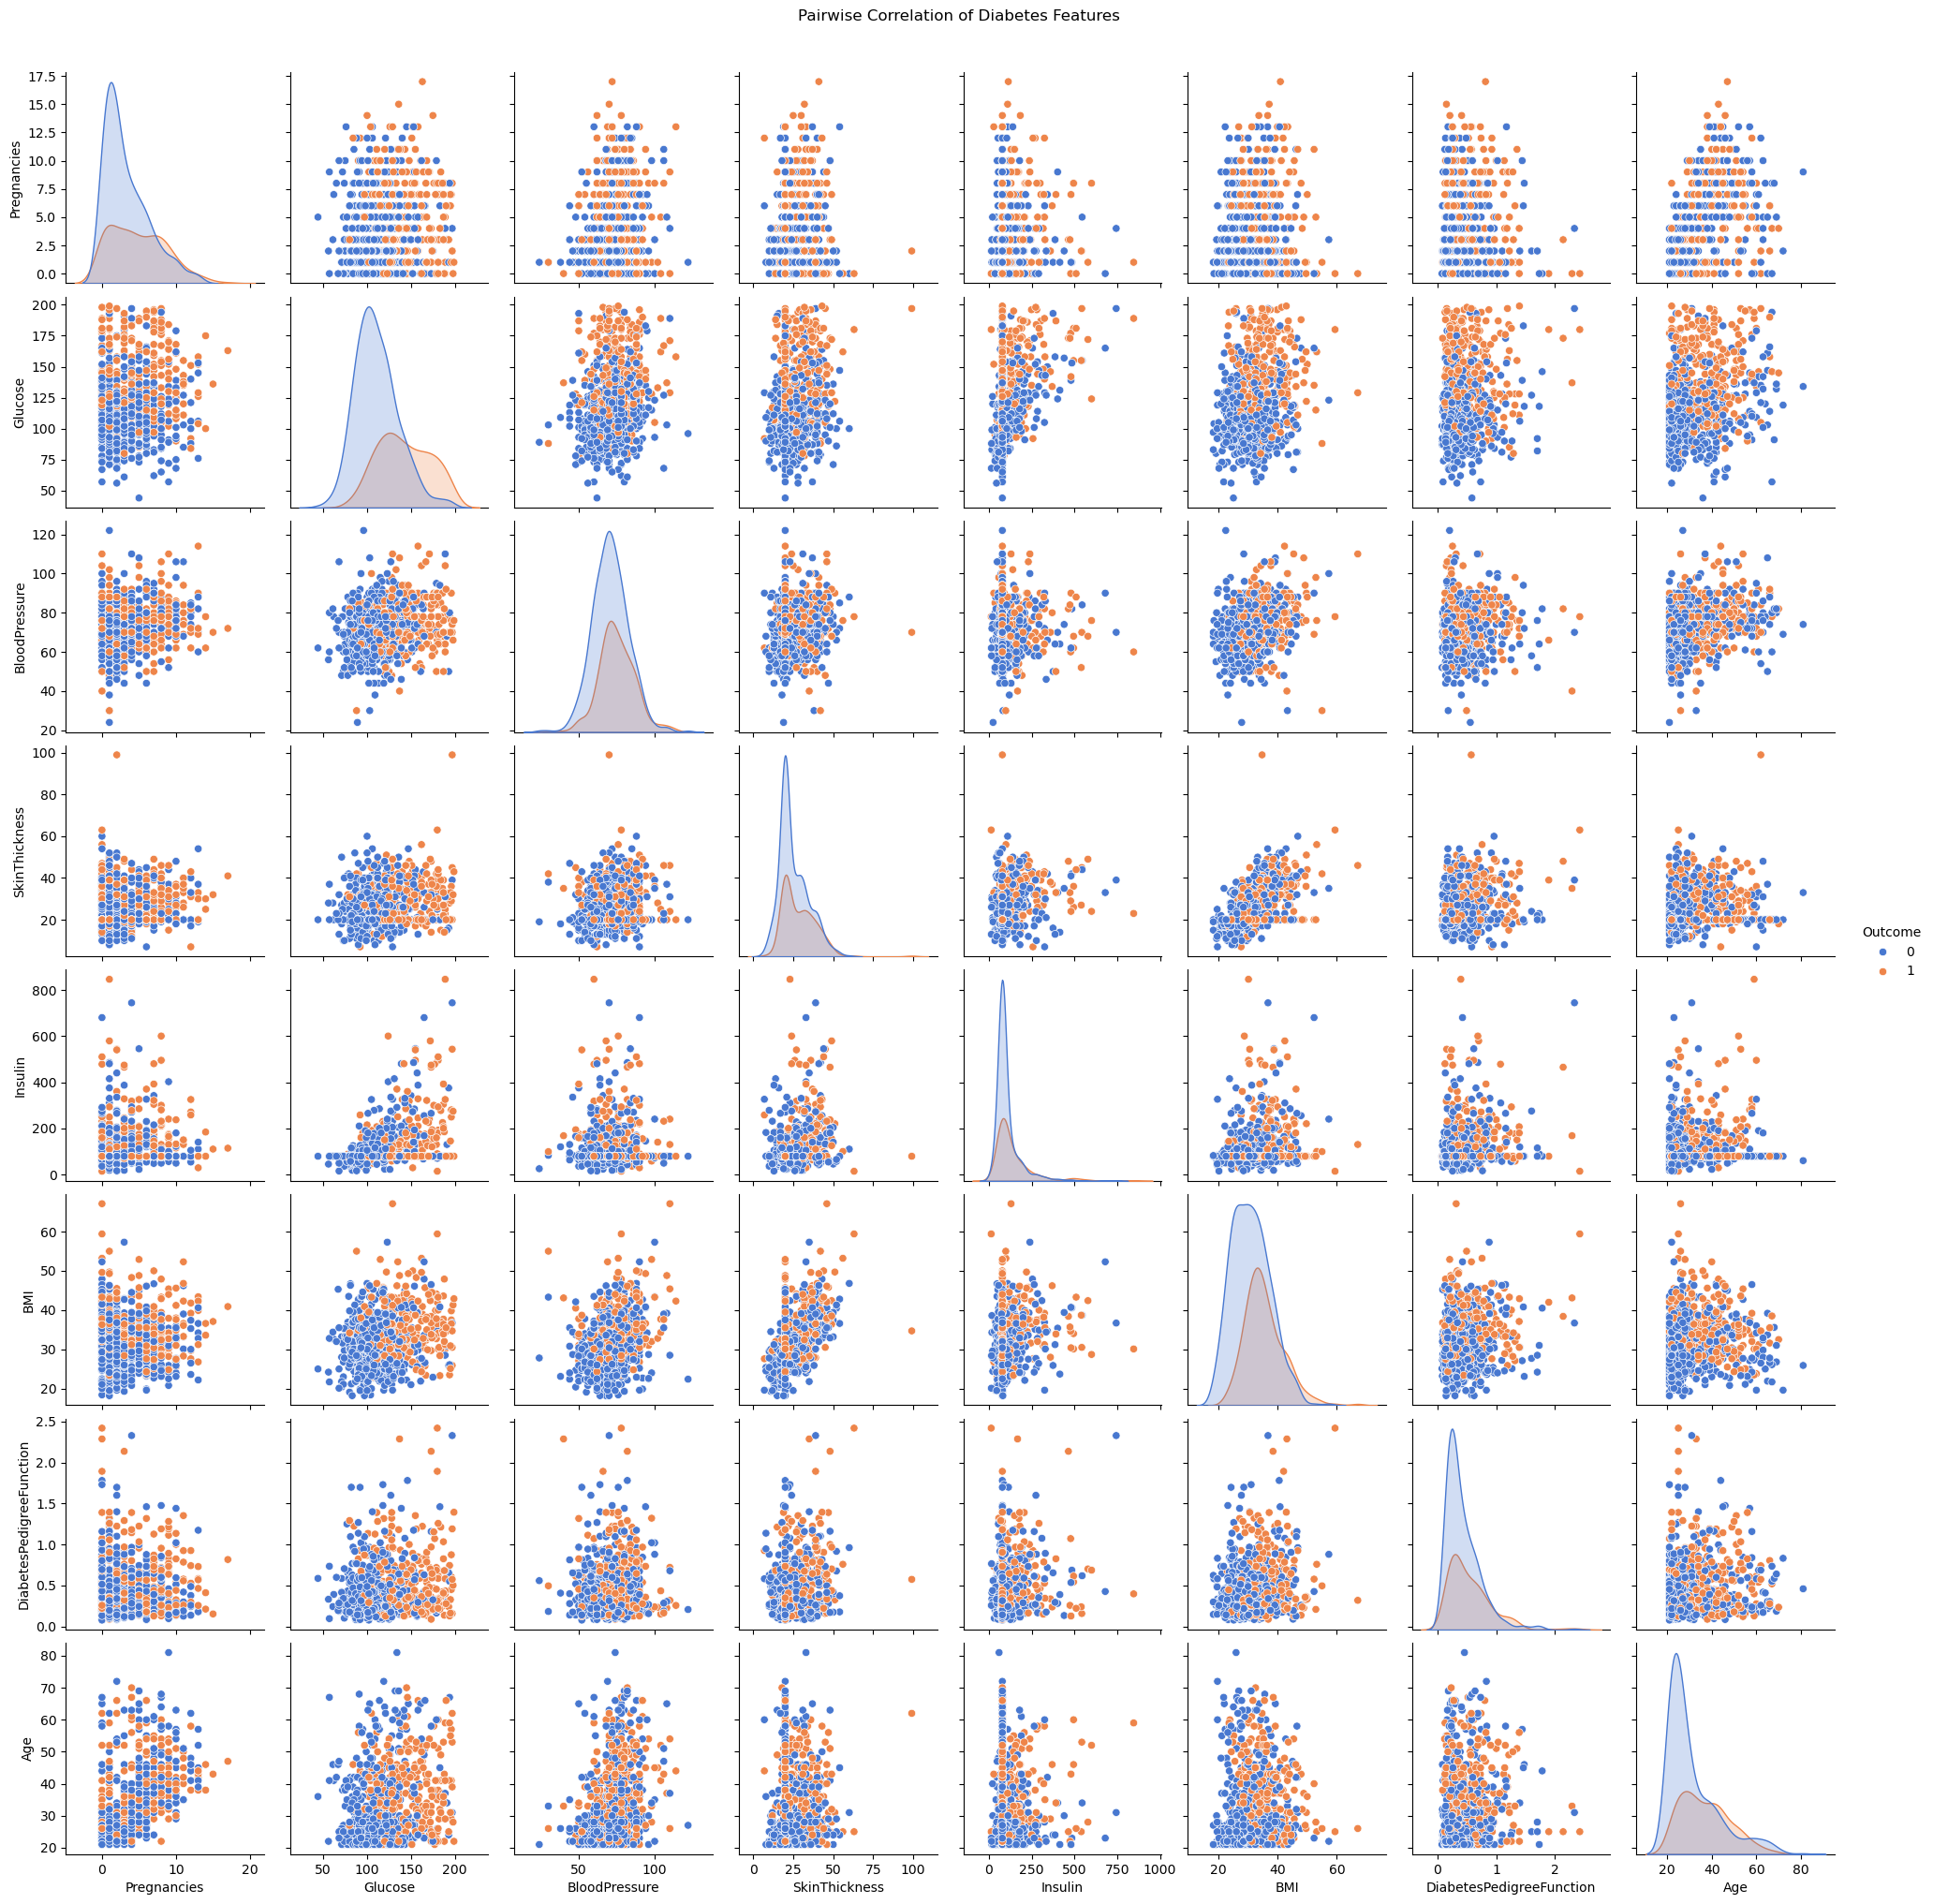

In [5]:
# Scatter plot of all features in dataset, to show correlation with outcome 

sns.pairplot(df, hue='Outcome', diag_kind='kde', palette='muted')
plt.suptitle('Pairwise Correlation of Diabetes Features', y=1.02)
plt.show()

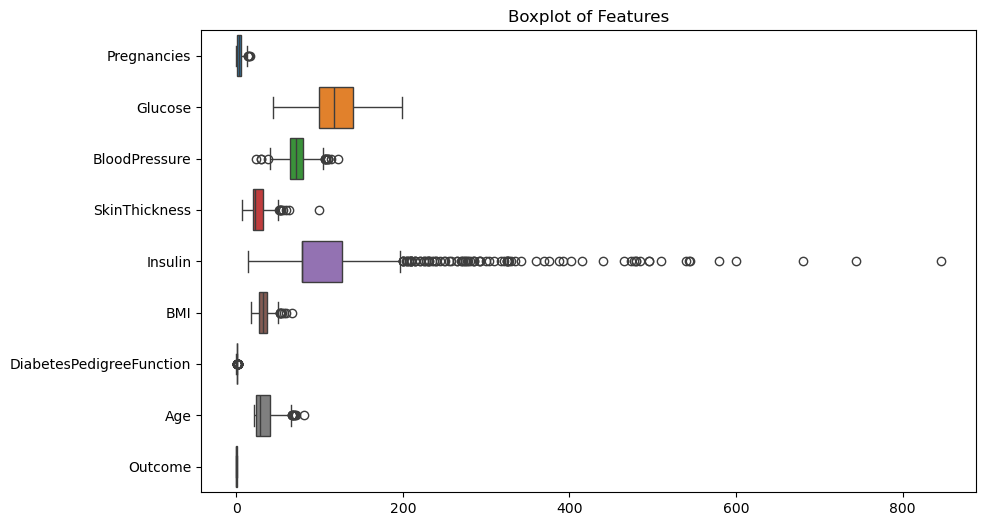

In [6]:
#Boxplot to show distribution of features 

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot of Features')
plt.show()

**Note:**

With the amount of potential missing and outliers in Insulin, we considered taking this out. However as we saw no benefit in our analysis with removing Insulin, we elected to keep it.

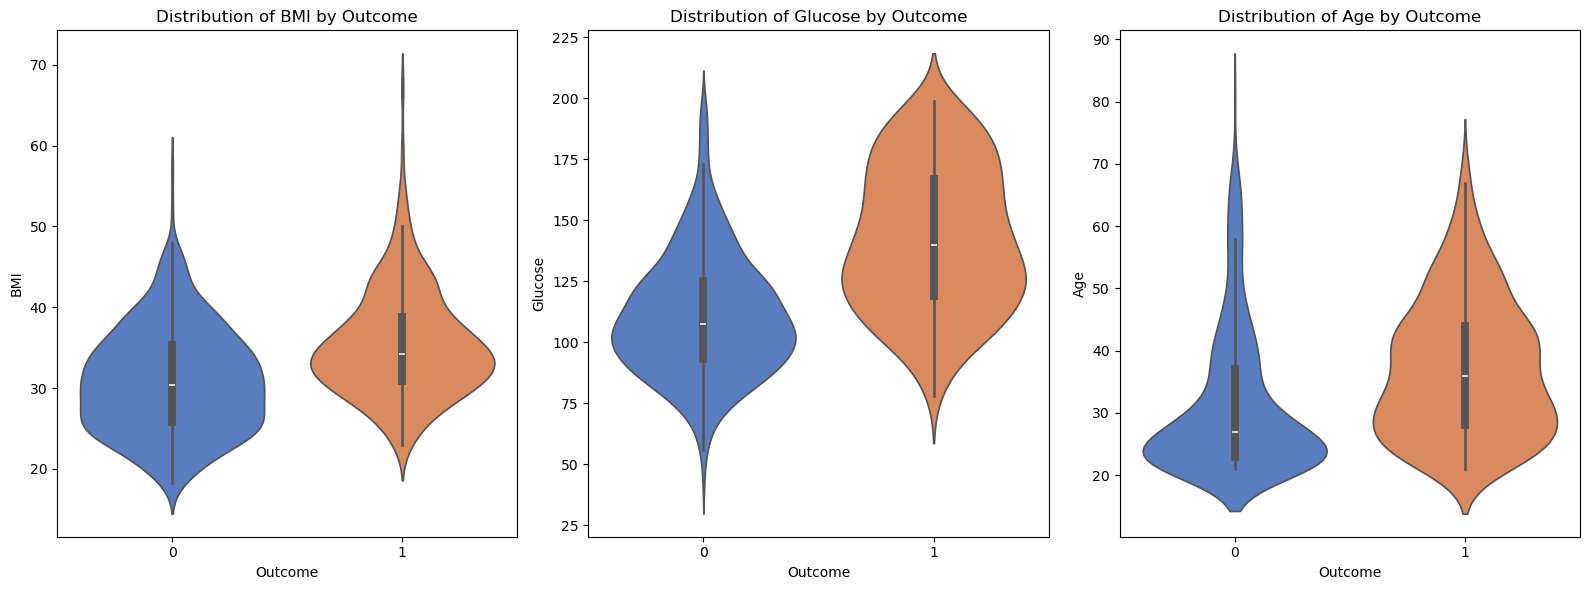

In [7]:
#Distribution of select features

plt.figure(figsize=(16, 6))

# Violin plot for BMI by Outcome
plt.subplot(1, 3, 1)
sns.violinplot(data=df, x='Outcome', y='BMI', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of BMI by Outcome')

# Violin plot for Glucose by Outcome
plt.subplot(1, 3, 2)
sns.violinplot(data=df, x='Outcome', y='Glucose', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of Glucose by Outcome')

# Violin plot for Age by Outcome
plt.subplot(1, 3, 3)
sns.violinplot(data=df, x='Outcome', y='Age', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of Age by Outcome')

plt.tight_layout()
plt.show()

**Feature Vectorization**

Checking if there are any outliers that should be removed. (Nothing stood out, no points were removed.)

In [8]:
###Feature Vectorization
print(df.info()) #All data is already numerical or encoded properly

print(df.describe().T) #Data has varying scales, we need to normalize it
diabetes_df = df.copy()

X, y = df.iloc[:,:-1], df.iloc[:, -1]

# Scale the input features
X_normal = StandardScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
                          count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  121.675781  30.436252  44.000  99.75000   
BloodPr

## Anomaly Detection: Outliers

In [9]:
### Outlier Check:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.05).fit(X_normal)

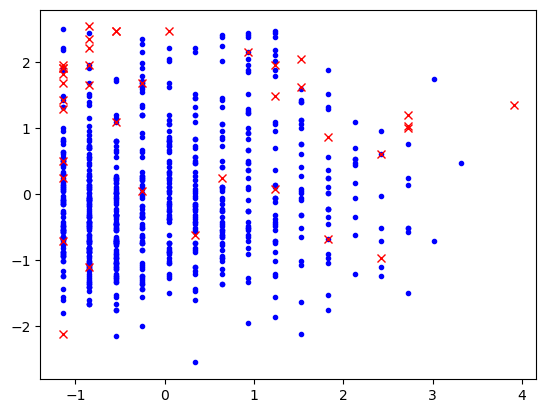

In [10]:
predictions = iforest.predict(X_normal)
# Plot the normal points
plt.plot(X_normal[predictions == 1][:, 0], X_normal[predictions == 1][:, 1], 'b.')

# Plot the anomalous points
plt.plot(X_normal[predictions == -1][:, 0], X_normal[predictions == -1][:, 1], 'rx')

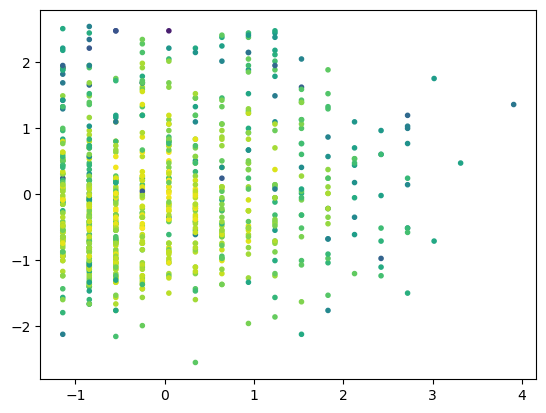

In [11]:
plt.scatter(X_normal[:, 0], X_normal[:, 1], c=iforest.decision_function(X_normal), marker='.')

In [12]:
dfo = pd.DataFrame(dict(predicted_label=iforest.predict(X_normal), score=iforest.decision_function(X_normal)))
outliers = dfo[dfo['predicted_label'] == -1].values
inliers = dfo[dfo['predicted_label'] == 1].head(len(outliers)).values
outliers_df = pd.DataFrame(np.concatenate([inliers, outliers], axis=1), 
             columns=['Inlier Label', 'Inline Score', 'Outlier Label', 'Outline Score'])
outliers_df = outliers_df.sort_values(by='Outline Score', ascending=True)
print(outliers_df.head())


    Inlier Label  Inline Score  Outlier Label  Outline Score
22           1.0      0.115862           -1.0      -0.137742
11           1.0      0.093010           -1.0      -0.113153
19           1.0      0.066801           -1.0      -0.093273
1            1.0      0.135017           -1.0      -0.063278
13           1.0      0.033757           -1.0      -0.062561


**Note:**

Ultimatly none of these outliers are significant enough to remove, they are each very low

## Dimensionality Reduction: PCA

In [13]:
#Initial fit for PCA models, both normalized and raw data
pca_normalized = PCA(n_components=2).fit(X_normal)
pca_raw = PCA(n_components=2).fit(X)

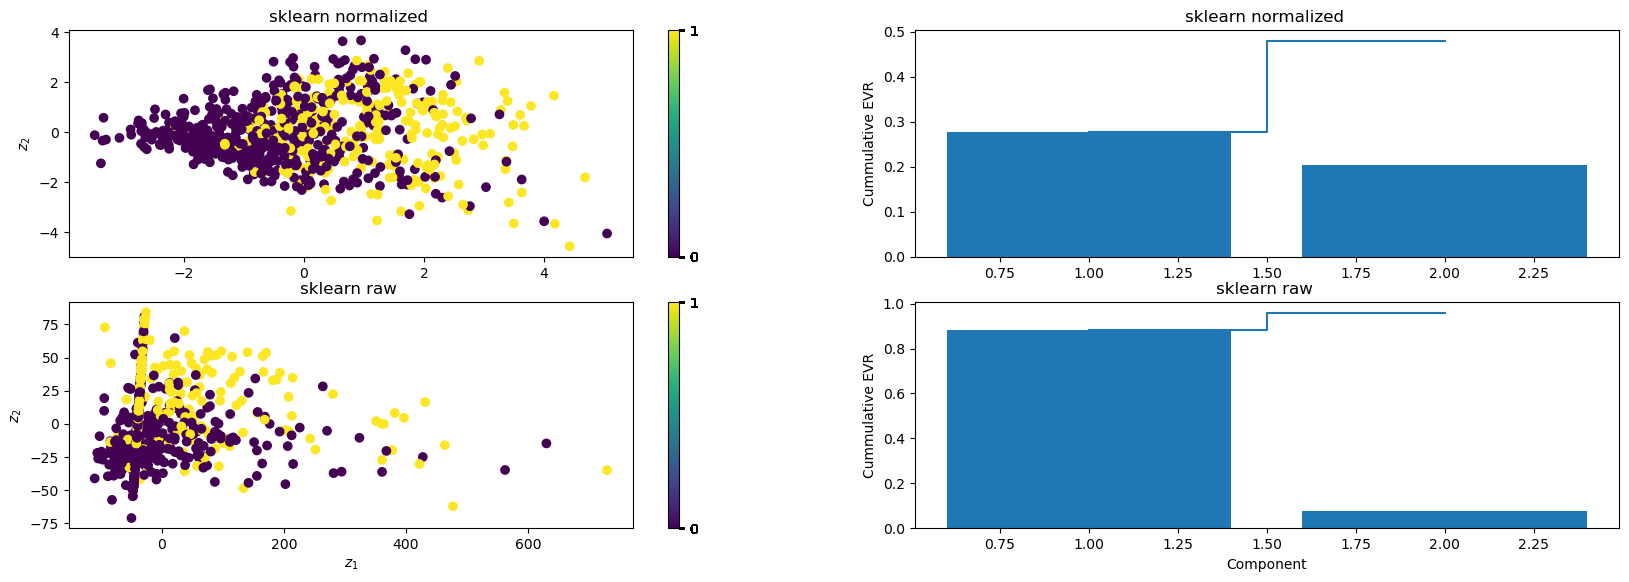

In [14]:
#Visualize the PCA models
fig = plt.figure(figsize=(20, 10))

for i, pca, title in [(1, pca_normalized, "sklearn normalized "), 
                      (3, pca_raw, "sklearn raw ")]:
    X_projected = pca.transform(X_normal if i < 3 else X)

    plt.subplot(3, 2, i)
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y)
    cb = plt.colorbar()
    cb.set_ticks(y)
    if i != 1: plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title(title)

    expl_var = pca.explained_variance_ratio_
    cum_expl_var = np.cumsum(expl_var)

    plt.subplot(3, 2, i + 1)
    plt.bar(range(1, len(expl_var) + 1), expl_var, align='center')
    plt.ylabel('EVR')
    if i != 1: plt.xlabel('Component')

    plt.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')
    plt.ylabel("Cummulative EVR")
    if i != 1: plt.xlabel('Component')
    plt.title(title)

**Note:**

Normalized looks better than raw, but not a great job at separating the classes

In [15]:
# See which features contributed most to the PCA components
eigen_vals, eigen_vecs = np.linalg.eig(np.cov(X_normal.T))
loadings = eigen_vecs * np.sqrt(eigen_vals)

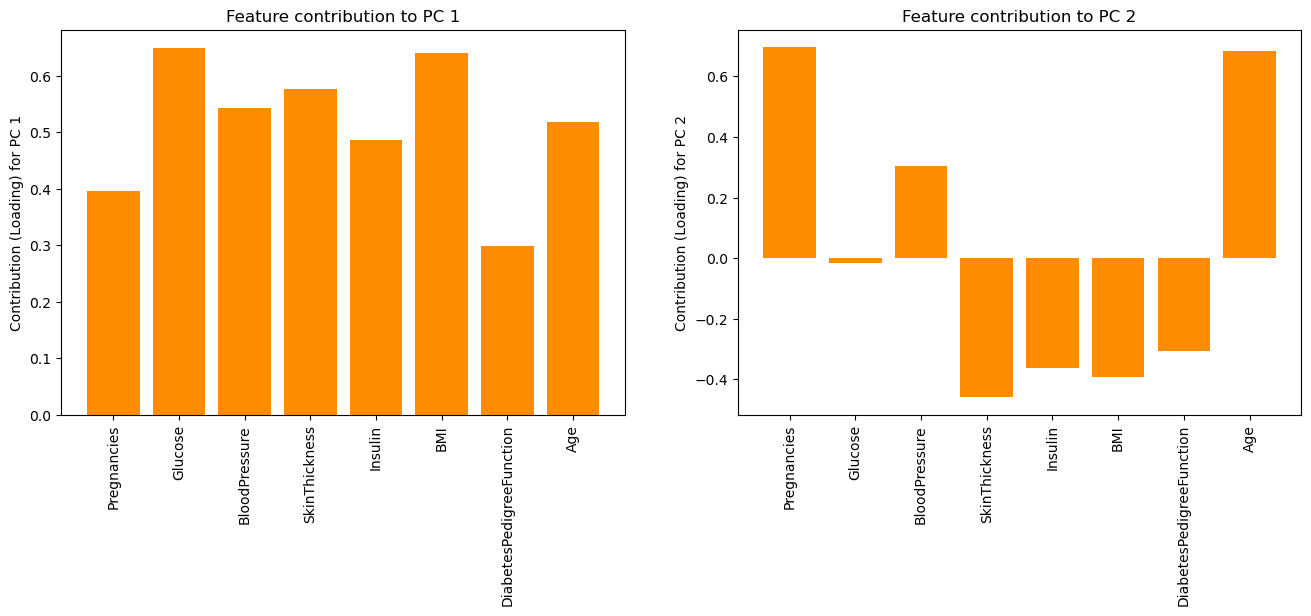

In [16]:
fig = plt.figure(figsize=(16, 5))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.bar(range(X_normal.shape[1]), loadings[:, i], align='center', color="darkorange")
    plt.ylabel(f"Contribution (Loading) for PC {i + 1}")
    plt.xticks(range(8), labels=df.columns[:-1], rotation=90)
    plt.title(f"Feature contribution to PC {i + 1}")

**Note:**

Glucose and BMI for PC1, Pregnancies and Age for PC2

**Additional PCA methods to see if there is a better way**

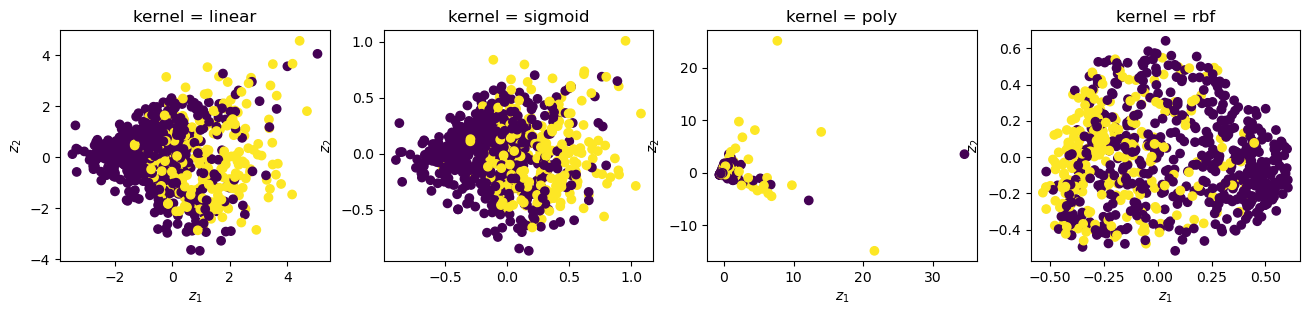

In [17]:
from sklearn.decomposition import KernelPCA
fig = plt.figure(figsize=(16, 3))

for i, k in enumerate(["linear", "sigmoid", "poly", "rbf"]):
    plt.subplot(1,4, i + 1)
    k_pca = KernelPCA(n_components=2, kernel=k)
    X_projected = k_pca.fit_transform(X_normal)
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y)
    if i != 1: plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title(f"kernel = {k}")

**Note:**

Overall none of the PCA methods did a great job at separating the classes completely.

## KMeans

c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmea

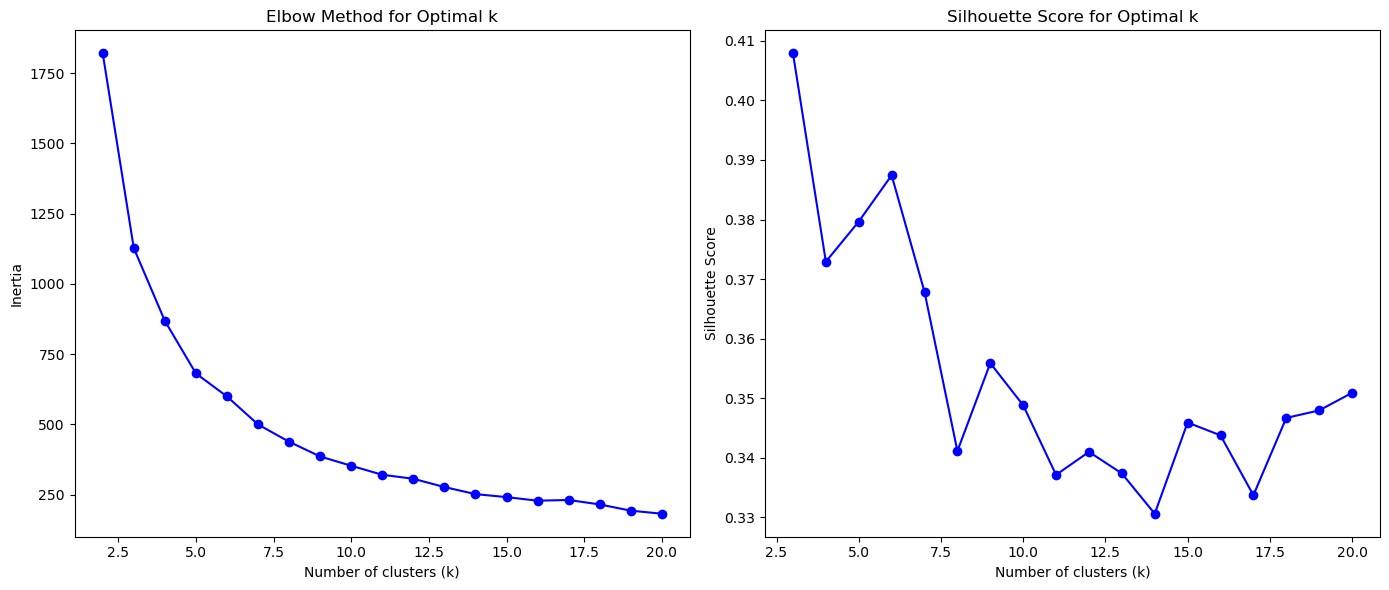

In [18]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X_pca = PCA(n_components=2).fit_transform(X_normal) #Use PCA to reduce the dimensionality of X

K = np.arange(2, 21)
models = [ KMeans(k).fit(X_pca) for k in K ]

# Elbow Method
inertia = [model.inertia_ for model in models]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette Score
silhouette_scores = []
for k in K[1:]:  # Silhouette score is not defined for k=1
    model = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    labels = model.labels_
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.subplot(1, 2, 2)
plt.plot(K[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

**Note:**

Not a clear elbow, decided on 3 clusters

In [19]:
##Looks like 3 is my spot

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=3).fit(X_pca)
print(f"Inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(X_pca, kmeans.labels_)}")

Inertia: 1127.4277803543105
Silhouette Score: 0.4079931446117495


c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


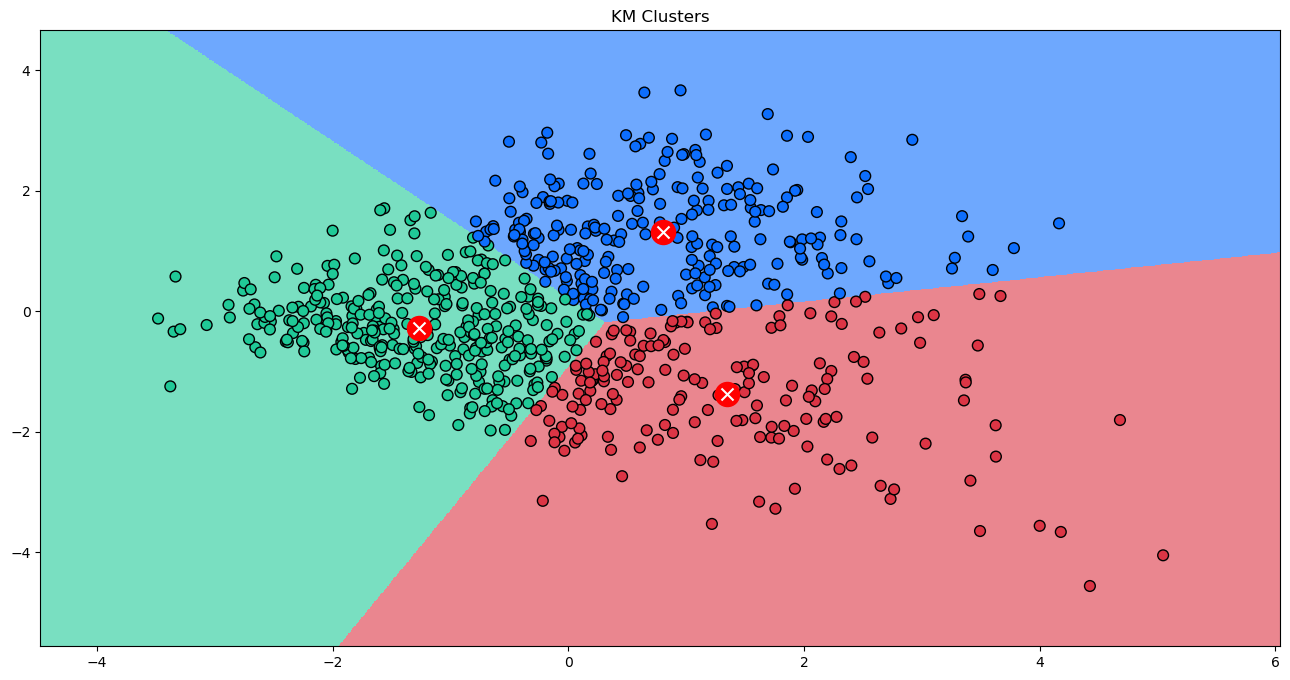

In [20]:
###Plot the KMeans

my.plot_decision_regions(X_pca, kmeans.predict(X_pca).reshape(len(X_pca), 1), kmeans, resolution=0.01, title="KM Clusters")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c="w", marker="x", s=75)

In [21]:
from sklearn.metrics.cluster import normalized_mutual_info_score

print("KMeans:", normalized_mutual_info_score(y, kmeans.labels_))

KMeans: 0.09667562506392603


**Interpretation:**

Only about 10% of points were properly clustered, this isn't a great method to analyze this data

## Decision Tree

In [22]:
#Split by features and outcome into arrays

X = diabetes_df.iloc[:, :-1].values
y = diabetes_df.iloc[:, -1].values

In [23]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [24]:
# K-fold Cross Validation; Searching for best CV value

best_cv = 0
best_mean_accuracy = 0

dt = DecisionTreeClassifier(random_state=2) #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(dt, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.6726384364820847
CV: 3, Mean accuracy: 0.6856368563685636
CV: 4, Mean accuracy: 0.6986142942025294
CV: 5, Mean accuracy: 0.6710249233639878
CV: 6, Mean accuracy: 0.6563392347230154
CV: 7, Mean accuracy: 0.7067472757127929
CV: 8, Mean accuracy: 0.6530032467532467
CV: 9, Mean accuracy: 0.6676139054655679
CV: 10, Mean accuracy: 0.6804600740349022
Best CV value: 7 with mean accuracy: 0.7067472757127929


**Interpretation:**

Best Decision Tree model returned an accuracy of around 71%

In [25]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'max_depth': range(1, 16), 
    'max_features': range(1, 6), 
    'max_leaf_nodes': range(2, 50),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': range(2, 11)
}
dt = DecisionTreeClassifier(random_state=3) #Import Classifer 
gs = RandomizedSearchCV(dt, parameters, cv=best_cv) #Randomized search
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=7, estimator=DecisionTreeClassifier(random_state=3),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 16),
                                        'max_features': range(1, 6),
                                        'max_leaf_nodes': range(2, 50),
                                        'min_samples_split': range(2, 11),
                                        'splitter': ['best', 'random']})

In [26]:
gs.best_score_, gs.best_params_

(0.7296051649499925,
 {'splitter': 'random',
  'min_samples_split': 5,
  'max_leaf_nodes': 4,
  'max_features': 4,
  'max_depth': 15,
  'criterion': 'entropy'})

Accuracy: 0.7857142857142857


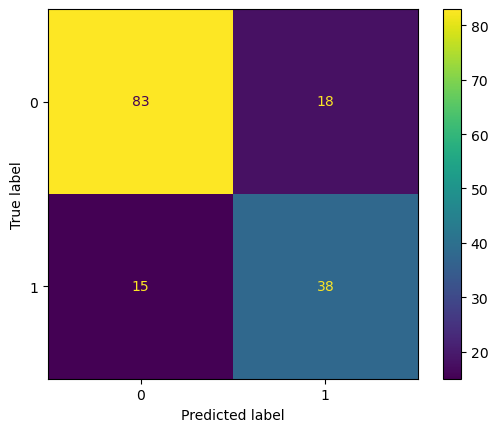

In [27]:
#Training data and plotting confusion matrix

dt = DecisionTreeClassifier(random_state=4, 
                            max_depth=gs.best_params_['max_depth'], 
                            max_features=gs.best_params_['max_features'],
                            max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                            criterion=gs.best_params_['criterion'],
                            splitter=gs.best_params_['splitter'],
                            min_samples_split=gs.best_params_['min_samples_split']) 
dt.fit(X_train, y_train)
my.plot_confusion_matrix_with_accuracy(dt, X_test, y_test)

**Interpretation:**

Accuracy of 78%

In [28]:
import optuna

# Optuna (Decision Tree Classifier)
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    cv = trial.suggest_int('cv', 2, 10)

    dt = DecisionTreeClassifier(
        random_state=22,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter
    )
    
    best_score = cross_val_score(dt, X_train, y_train, cv=cv)
    return best_score.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Fit the Decision Tree model with the best Optuna hyperparameters
best_params = study.best_trial.params
dt_best_optuna = DecisionTreeClassifier(
    random_state=22,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    splitter=best_params['splitter']
)
dt_best_optuna = dt_best_optuna.fit(X_train, y_train)

[I 2024-12-03 19:14:49,111] A new study created in memory with name: no-name-947952ec-b8f7-45d8-8b75-49e7330c53de
[I 2024-12-03 19:14:49,161] Trial 0 finished with value: 0.726461038961039 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 9, 'criterion': 'gini', 'splitter': 'best', 'cv': 8}. Best is trial 0 with value: 0.726461038961039.
[I 2024-12-03 19:14:49,177] Trial 1 finished with value: 0.7133550488599348 and parameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 1, 'criterion': 'entropy', 'splitter': 'best', 'cv': 2}. Best is trial 0 with value: 0.726461038961039.
[I 2024-12-03 19:14:49,230] Trial 2 finished with value: 0.7555791909240185 and parameters: {'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 15, 'criterion': 'entropy', 'splitter': 'best', 'cv': 7}. Best is trial 2 with value: 0.7555791909240185.
[I 2024-12-03 19:14:49,319] Trial 3 finished with value: 0.752368096997253 and parameters: {'max_depth': 14, 'min

Best trial: {'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 12, 'criterion': 'entropy', 'splitter': 'best', 'cv': 7}


Accuracy: 0.7467532467532467


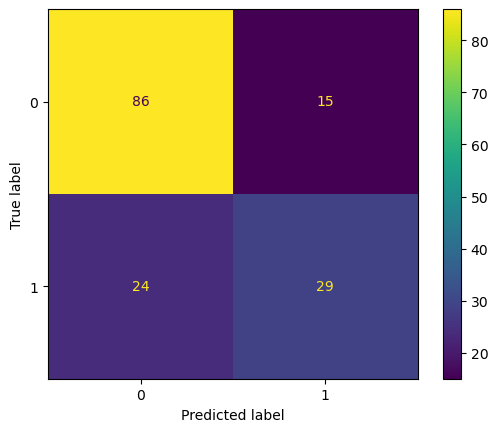

In [29]:
#Training data and plotting confusion matrix

dt_best_optuna.fit(X_train, y_train)
my.plot_confusion_matrix_with_accuracy(dt_best_optuna, X_test, y_test)

**Interpretation:**

Achieved an accuracy of 74% with Optuna parameterized model

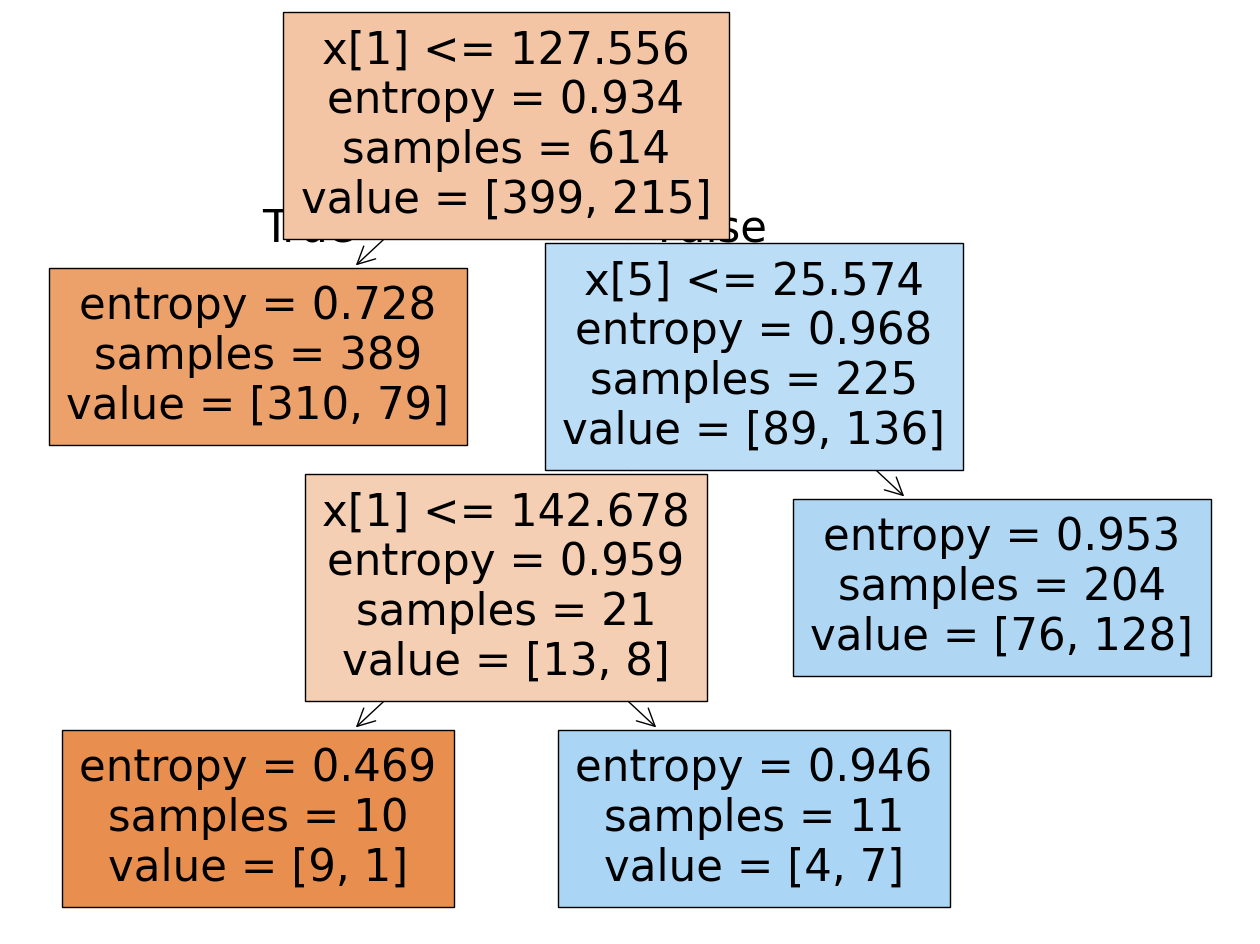

In [30]:
# Plot Decision Tree (RGS Model)

fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt, ax=ax, filled=True)
print('')

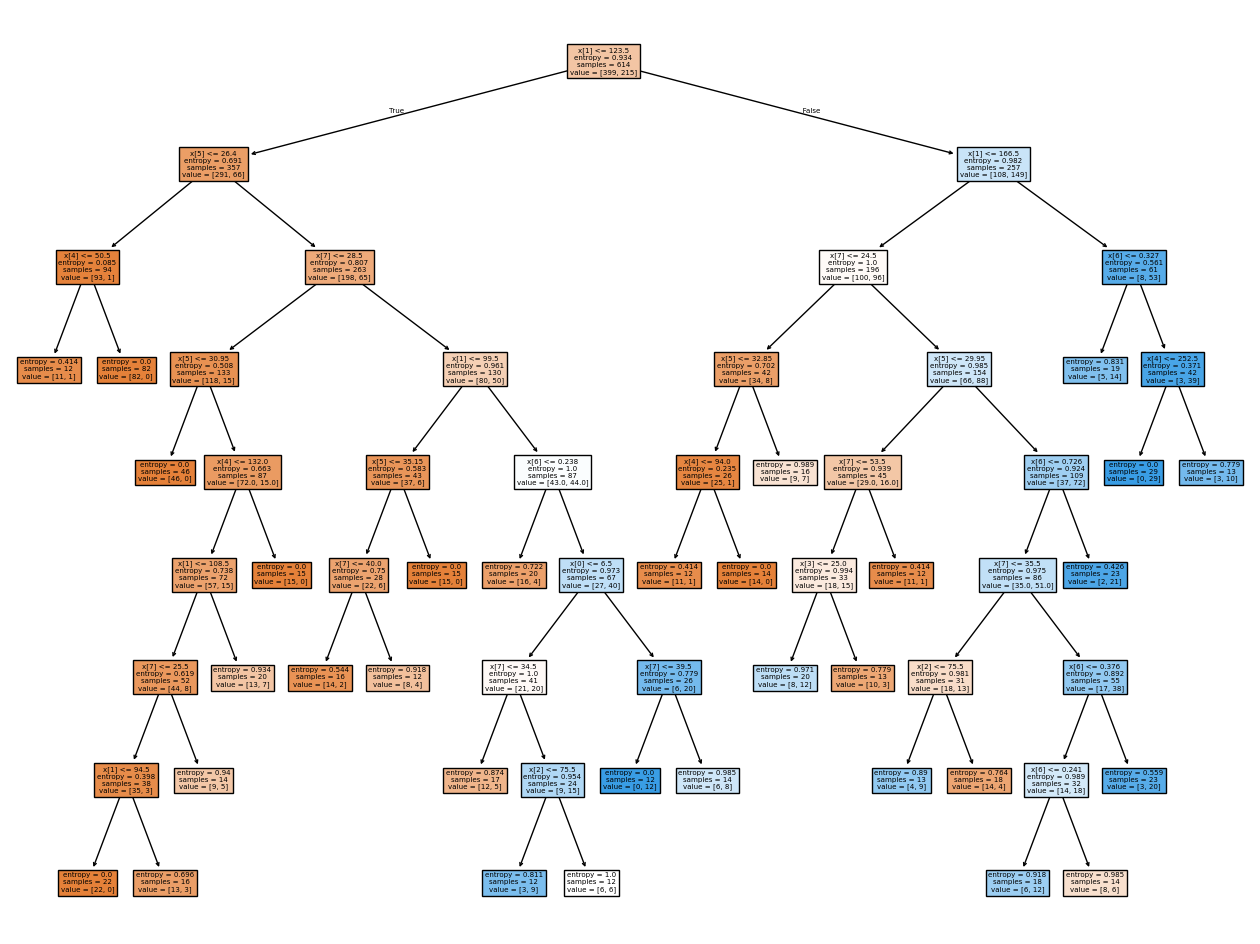

In [31]:
# Plot Decision Tree (Optuna Model)

fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt_best_optuna, ax=ax, filled=True)
print('')

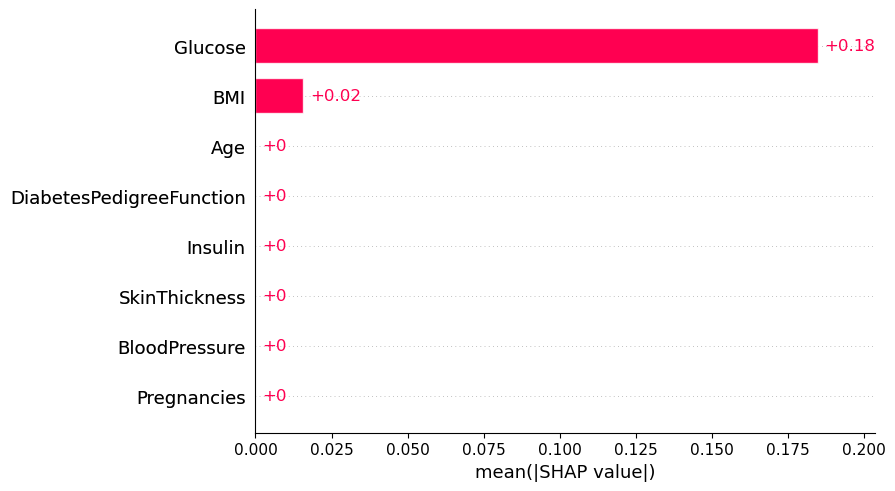

In [32]:
##SHAP
import shap
shap.initjs()
#print(shap.__version__) 0.42.1

feature_names = diabetes_df.columns[:-1]
explainer = shap.TreeExplainer(dt, feature_names=feature_names)
explanations = explainer(X_test)
shap.plots.bar(explanations[:, :, 0])


**Interpretation:**

Glucose, and BMI were the most important features for this decision tree

## Logistic Regression


In [33]:
#Split by features and outcome into arrays

X, y = diabetes_df.iloc[:, :-1].values, diabetes_df.iloc[:, -1].values

In [34]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [35]:
LogisticRegression().get_params() #Showing hyperparameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [36]:
#Looking at params for Pipeline
make_pipeline(StandardScaler(), LogisticRegression()).get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'deprecated',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [37]:
#K-Means Cross Validation

best_cv = 0
best_mean_accuracy = 0

logreg = LogisticRegression(random_state=5, max_iter=1000) #Import Classifer

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(logreg, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.744299674267101
CV: 3, Mean accuracy: 0.771983102183963
CV: 4, Mean accuracy: 0.7622655122655122
CV: 5, Mean accuracy: 0.7621884579501532
CV: 6, Mean accuracy: 0.7703851767244115
CV: 7, Mean accuracy: 0.7670174652933273
CV: 8, Mean accuracy: 0.7687115516062886
CV: 9, Mean accuracy: 0.7670976603201667
CV: 10, Mean accuracy: 0.764013749338974
Best CV value: 3 with mean accuracy: 0.771983102183963


**Interpretation:**

Best Logistic Regression Model with K-Means cross-validation achieved around 77% accuracy.

In [38]:
# Define param ranges to iterate through
param_grid = {
    'logisticregression__C': np.logspace(-4, 4, 10),
    'logisticregression__max_iter': range(100, 5001),
    'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet']
}

# Valid params initiation
valid_params = {
    'logisticregression__C': [],
    'logisticregression__max_iter': [],
    'logisticregression__solver': [],
    'logisticregression__penalty': []
}

param_list = list(ParameterSampler(param_grid, n_iter=100, random_state=6))

#Searching through valid param combinations and applying to pipeline
for params in param_list:
    solver = params['logisticregression__solver']
    penalty = params['logisticregression__penalty']
    is_valid = False  # Flag to check if the combination is valid

    # Check validity based on the table
    if solver == 'lbfgs' and penalty in ['l2']:
        is_valid = True
    elif solver == 'liblinear' and penalty in ['l1', 'l2']:
        is_valid = True
    elif solver == 'newton-cg' and penalty in ['l2']:
        is_valid = True
    elif solver == 'sag' and penalty in ['l2']:
        is_valid = True
    elif solver == 'saga' and penalty in ['elasticnet', 'l1', 'l2']:
        is_valid = True

    # Append valid combinations to valid_params
    if is_valid:
        valid_params['logisticregression__C'].append(params['logisticregression__C'])
        valid_params['logisticregression__max_iter'].append(params['logisticregression__max_iter'])
        valid_params['logisticregression__solver'].append(params['logisticregression__solver'])
        valid_params['logisticregression__penalty'].append(params['logisticregression__penalty'])

valid_params

pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=11))
gs_pipeline = RandomizedSearchCV(pipeline, param_distributions=valid_params, cv=best_cv, n_iter=50) # Randomized search
gs_pipeline = gs_pipeline.fit(X_train, y_train)



33 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nathan Losee\anaconda3\envs\torch\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users

In [39]:
#Showing best params output

gs_pipeline.best_score_, gs_pipeline.best_params_

(0.7736091184441256,
 {'logisticregression__solver': 'saga',
  'logisticregression__penalty': 'l2',
  'logisticregression__max_iter': 1606,
  'logisticregression__C': 166.81005372000558})

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       103
           1       0.68      0.63      0.65        51

    accuracy                           0.78       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154

Confusion Matrix:


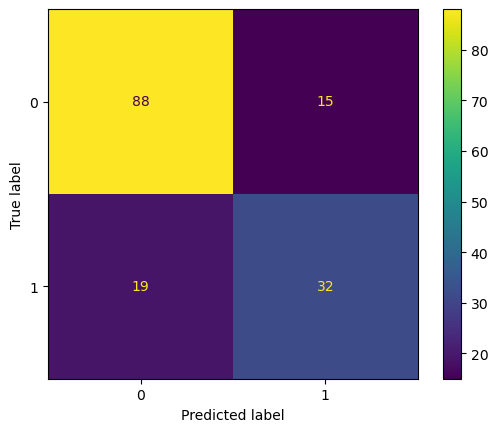

In [40]:
#Confusion matrix results for randomized search grid results

y_pred_gs = gs_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_gs))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(gs_pipeline, X_test, y_test)

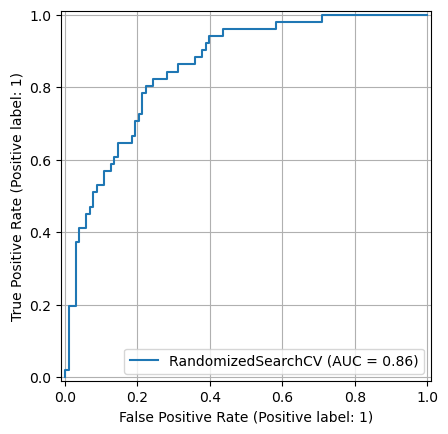

In [41]:
#ROC plot and AUC score to measure performance

RocCurveDisplay.from_estimator(gs_pipeline, X_test, y_test)
plt.grid()

In [42]:
import optuna

# Optuna (Logistic Regression)
def objective(trial):
    C = trial.suggest_float('C', 0.01, 100.0, log=False)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    cv = trial.suggest_int('cv', 2, 10)

    logreg = LogisticRegression(
        random_state=22,
        C=C,
        max_iter=max_iter,
        solver=solver,
        penalty=penalty,
    )
    
    best_score = cross_val_score(logreg, X_train, y_train, cv=cv)
    return best_score.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Fit the LogReg model with the best Optuna hyperparameters
best_params = study.best_trial.params
logreg_best_optuna = LogisticRegression(
    random_state=22,
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    solver=best_params['solver'],
    penalty=best_params['penalty']
)
logreg_best_optuna = logreg_best_optuna.fit(X_train, y_train)

[I 2024-12-03 19:15:11,718] A new study created in memory with name: no-name-7c69546f-bdde-464f-91fb-a1510aa918db
[I 2024-12-03 19:15:11,796] Trial 0 finished with value: 0.7670668147641833 and parameters: {'C': 20.853969130510674, 'max_iter': 2460, 'solver': 'liblinear', 'penalty': 'l2', 'cv': 8}. Best is trial 0 with value: 0.7670668147641833.
[I 2024-12-03 19:15:11,961] Trial 1 finished with value: 0.744299674267101 and parameters: {'C': 22.048247618606187, 'max_iter': 4079, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 2}. Best is trial 0 with value: 0.7670668147641833.
[I 2024-12-03 19:15:12,209] Trial 2 finished with value: 0.7637333930437379 and parameters: {'C': 77.20666670573918, 'max_iter': 4794, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 7}. Best is trial 0 with value: 0.7670668147641833.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not con

Best trial: {'C': 21.88085423804514, 'max_iter': 920, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 3}


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       103
           1       0.68      0.63      0.65        51

    accuracy                           0.78       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.78      0.78      0.78       154

Confusion Matrix:


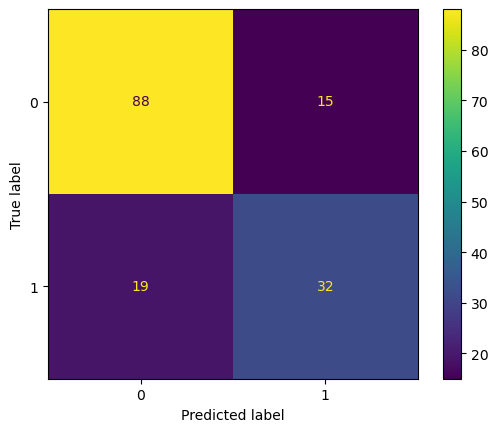

In [43]:
#Confusion matrix results for Optuna results

y_pred_optuna = logreg_best_optuna.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_optuna))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(logreg_best_optuna, X_test, y_test)


**Interpretation:**

Even With Optuna we still achieve around a 78% accuracy

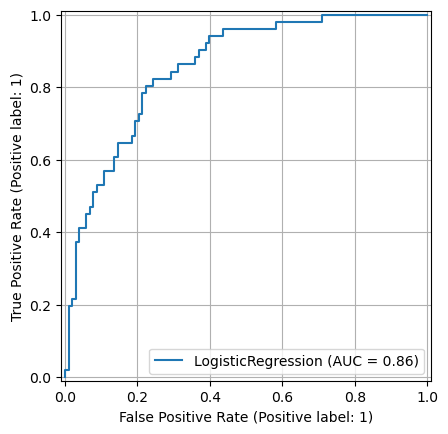

In [44]:
#ROC plot and AUC score to measure performance

RocCurveDisplay.from_estimator(logreg_best_optuna, X_test, y_test)
plt.grid()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


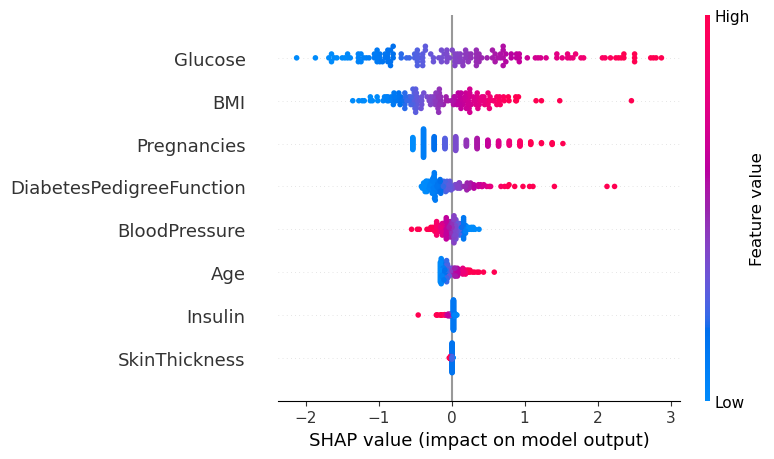

In [45]:
# Create a SHAP explainer
best_pipeline = gs_pipeline.best_estimator_
explainer = shap.Explainer(best_pipeline.named_steps['logisticregression'], best_pipeline.named_steps['standardscaler'].transform(X_train))

# Calculate SHAP values for the test data
shap_values = explainer(best_pipeline.named_steps['standardscaler'].transform(X_test))

# Convert X_test to a DataFrame if it's not already
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)  # Replace feature_names with the actual feature names
else:
    X_test_df = X_test

# Create an Explanation object
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_df, feature_names=X_test_df.columns)

# Plot SHAP values for a single prediction
shap.initjs()
shap.force_plot(shap_explanation[0])

# Summary plot of SHAP values for all predictions
shap.summary_plot(shap_explanation)

**Interpretation:**

Glucose, BMI, Pregnancies, and the Diabetes Pedigree Function were the most important features for this model.

## Support Vector Machine (SVM)

In [46]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df.iloc[:, -1].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [48]:
# K-fold Cross Validation; Searching for best CV value

best_cv = 0
best_mean_accuracy = 0

svm_classifier = SVC(probability=True) #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(svm_classifier, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.749185667752443
CV: 3, Mean accuracy: 0.7377490833731867
CV: 4, Mean accuracy: 0.7458938120702827
CV: 5, Mean accuracy: 0.7442889510862322
CV: 6, Mean accuracy: 0.742670854749667
CV: 7, Mean accuracy: 0.7409874608150471
CV: 8, Mean accuracy: 0.7410500683526999
CV: 9, Mean accuracy: 0.7442218433267027
CV: 10, Mean accuracy: 0.7426493918561606
Best CV value: 2 with mean accuracy: 0.749185667752443


**Interpretation:**

The best SVM model using K-fold cross validation achieved 75% accuracy

In [49]:
#List hyperparameters

SVC(probability=True).get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [50]:
#Viewing SVM pipeline params 

pipeline  = make_pipeline(SVC(probability=True))
pipeline.get_params()

{'memory': None,
 'steps': [('svc', SVC(probability=True))],
 'verbose': False,
 'svc': SVC(probability=True),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [51]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'svc__C': range(1, 101),    
    'svc__degree': [1, 2, 3],
    'svc__kernel': ['poly', 'linear', 'rbf', 'sigmoid']
}
svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True, random_state=33))
svm_gs_pipeline = RandomizedSearchCV(svm_pipeline, parameters, cv=best_cv) #Randomized search
svm_gs_pipeline.fit(X_train, y_train)


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc',
                                              SVC(probability=True,
                                                  random_state=33))]),
                   param_distributions={'svc__C': range(1, 101),
                                        'svc__degree': [1, 2, 3],
                                        'svc__kernel': ['poly', 'linear', 'rbf',
                                                        'sigmoid']})

In [52]:
svm_gs_pipeline.best_score_, svm_gs_pipeline.best_params_

(0.7703583061889251, {'svc__kernel': 'linear', 'svc__degree': 3, 'svc__C': 45})

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       103
           1       0.82      0.53      0.64        51

    accuracy                           0.81       154
   macro avg       0.81      0.74      0.75       154
weighted avg       0.81      0.81      0.79       154

Confusion Matrix:


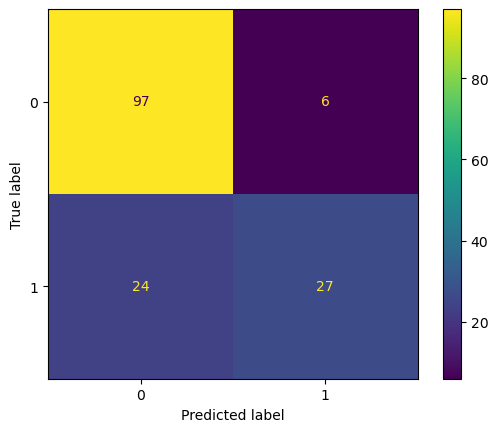

In [53]:
y_pred = svm_gs_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(svm_gs_pipeline, X_test, y_test)


**Interpretation:**

Randomized Grid Search imporved our accuracy to 81%

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


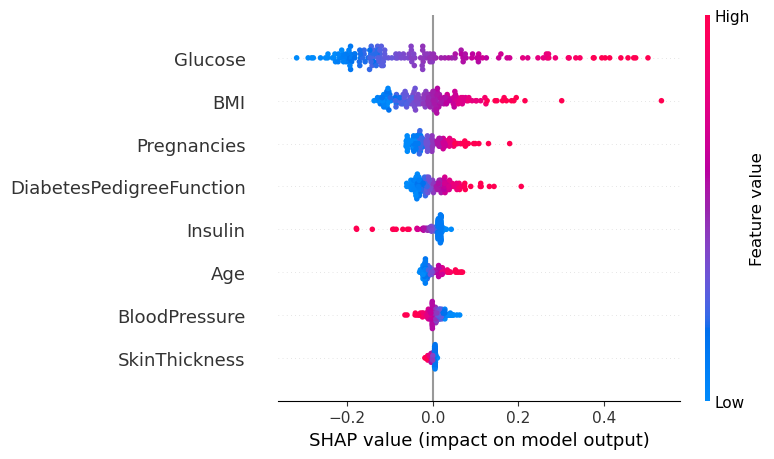

In [54]:
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)  # Replace feature_names with the actual feature names
else:
    X_train_df = X_train

if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)  # Replace feature_names with the actual feature names
else:
    X_test_df = X_test

# Create a SHAP explainer
explainer = shap.KernelExplainer(svm_gs_pipeline.predict_proba, X_train_df)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_df)

# Visualize SHAP values
shap.summary_plot(shap_values[1], X_test_df, feature_names=X_test_df.columns)

**Interpretation:**

Once again, Glucose, BMI, Pregnancies, and the Diabetes Pedigree Function were the most important features to this model.

**Note:**

Tried to run Optuna for SVM, but very computationally expensive, and takes a very long time with our dataset. We were able to get a decent accuracy score using RandomizedSearch, so not including Optuna in our pipeline, or running for comparison. 